# First Score Model

Paper: https://arxiv.org/abs/1907.05600

In [23]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn


Using torch 1.13.1


In [24]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_perturbations, embed_dim=4):
        super().__init__()

        # 'Attach' a time onto our input data
        self.embedding = nn.Embedding(num_perturbations, embed_dim)

        # Layer stack 
        self.layers = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 128),  
            nn.ReLU(),
            nn.Linear(128, 128),  
            nn.ReLU(), 
            nn.Linear(128, 128),  
            nn.ReLU(), 
            nn.Linear(128, output_dim)
        )

    def forward(self, X, sigma_idx):
        
        # Apply embedding to 't'
        sigma_embedded = self.embedding(sigma_idx.flatten())
        X_embedded = torch.cat([X, sigma_embedded], dim=1)  # Concatenate along dimension 1

        return self.layers(X_embedded)

In [25]:
class Diffuser:
    def __init__(self, num_perturbations, sigma_range=(0.01, 0.5), device='cuda'):
        self.device = device
        self.perturbations = num_perturbations
        numpy_sigmas = torch.from_numpy(np.geomspace(sigma_range[0], sigma_range[1], num_perturbations))
        self.sigmas = numpy_sigmas.flip(0).float().to(device)
        
    def forwards_diffusion(self, x0, t):

        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0, device=self.device)

        # 2. Multiply to change standard deviation --> mean = 0, var = sigma**2 * var(noise) * I
        std_dev = self.sigmas[t] * noise

        # 3. Perturb sample
        sample = x0 + std_dev
        
        return sample.float(), self.sigmas[t]


In [26]:
def loss_function(model_score, X, perturbed_X, sigma):
    
    # Find score of latent conditional distribution
    grad_log_q = (perturbed_X - X) / (sigma**2)
    
    # Calculate loss
    loss = (sigma * (model_score + grad_log_q) ** 2).sum(dim=-1).mean(dim=0)
    
    return loss

In [27]:
class Sampler:
    def __init__(self, epsilon, timesteps, num_samples, device='cpu') -> None:
        self.device = device
        self.eps = torch.tensor(epsilon, device=self.device) 
        self.timesteps = timesteps
        self.samples = num_samples
    
    def sampling_loop(self, model, diffuser):

        # Get the final sigma
        sigma_T = diffuser.sigmas[-1]
        
        # Take the latent from the standard Gaussian distribution
        x_t = torch.randn(size=(self.samples, 2), device=self.device)
        
        with torch.no_grad():
            # For each noise
            for i in range(diffuser.perturbations):
                tensor_step = torch.ones(self.samples, 1, device=self.device, dtype=torch.int) * i
                
                # Extract the noisy step size
                alpha_i = self.eps * (diffuser.sigmas[i]/sigma_T)**2

                # Paper notation: for t in T
                for t in range(self.timesteps):
                    
                    # Sample from standard gaussian
                    z = torch.randn_like(x_t, device=self.device)

                    # Langevin update step
                    x_t = x_t + ((alpha_i/2) * model(x_t, tensor_step)) + (torch.sqrt(alpha_i) * z)

        return x_t

In [28]:
def train_step(model, diffuser, X, optimiser, loss_fn):

    # Choose a random step in the entire perturbation schedule
    step = torch.randint(0, diffuser.perturbations, (X.shape[0],1), device = diffuser.device)
    sigma_step = diffuser.sigmas[step]
    
    # Perturb X
    perturbed_X = X + (torch.randn_like(X) * sigma_step)

    # 1. Forward pass
    pred_score = model(perturbed_X, step)

    # 2. Calc loss
    loss = loss_fn(pred_score, X, perturbed_X, sigma_step)

    # 3. Optimizer zero-grad
    optimiser.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Update -- gradient ascent
    optimiser.step() 

    return loss.item()

  0%|          | 0/3000 [00:00<?, ?it/s]

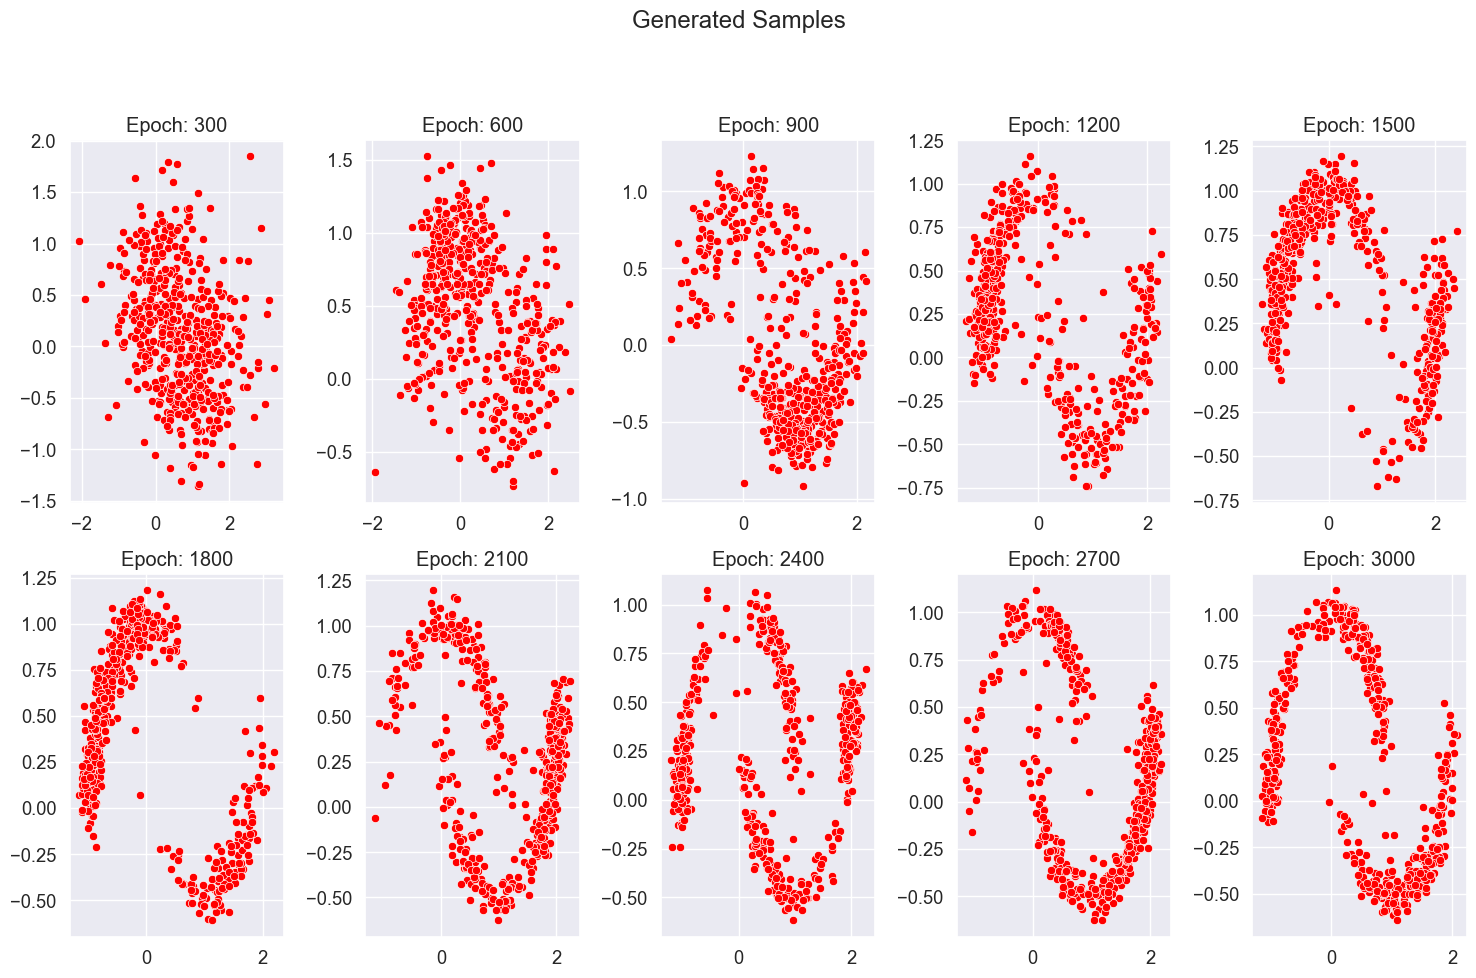

In [34]:
# Hyperparams
EPOCHS = 3000
PERTURBATIONS = 100
TIMESTEPS = 100
SAMPLES = 1000
EPSILON = 1e-6
LR = 1e-3
BATCH_SIZE = 128
SIGMA_RANGE = (0.001, 10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the moons dataset
X, _ = make_moons(n_samples=SAMPLES, noise=0.05, random_state=42)
X = torch.tensor(X).float().to(device)

sampler = Sampler(epsilon=EPSILON, 
                  timesteps = TIMESTEPS, 
                  num_samples = SAMPLES//2, 
                  device = device)

net = ScoreNet(input_dim = X.shape[1], 
               output_dim = X.shape[1],
               num_perturbations=PERTURBATIONS).to(device)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser(num_perturbations=PERTURBATIONS,sigma_range=SIGMA_RANGE, device=device)

optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = loss_function

# Determine the number of batches
num_batches = (len(X) - 1) // BATCH_SIZE + 1

# Calculate the number of rows and columns for subplots
sample_every = EPOCHS//10
num_plots = (EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(1, EPOCHS+1))

for epoch in tqdm_bar:
    avg_loss_epoch = 0

    for batch_idx in range(num_batches):

        # Collect batch
        start_index = batch_idx * BATCH_SIZE
        end_index = min((batch_idx + 1) * BATCH_SIZE, len(X))
        X_batch = X[start_index:end_index]

        loss= train_step(model = net, 
                            diffuser = D,
                            X = X_batch, 
                            optimiser = optimiser, 
                            loss_fn = loss_function)
        
        avg_loss_epoch += loss

    avg_loss_epoch /= num_batches
    tqdm_bar.set_description(f"Epoch {epoch}, Average Loss: {avg_loss_epoch:.4f}")
            
    if (epoch % sample_every == 0 or epoch == EPOCHS) and (epoch > 0):
                with torch.no_grad():
                        
                        # Draw samples from noisy dist using score net
                        x0 = sampler.sampling_loop(model=net, diffuser=D)
                        
                        plot_num = (epoch // sample_every) - 1
                        row = plot_num // num_cols
                        col = (plot_num % num_cols)

                        # Plot x0 on the specified subplot
                        sns.scatterplot(x=x0[:, 0].cpu().numpy(), y=x0[:, 1].cpu().numpy(),
                        color='red', marker='o', ax=axs[row, col])

                        axs[row, col].set_title(f'Epoch: {epoch}')
                
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

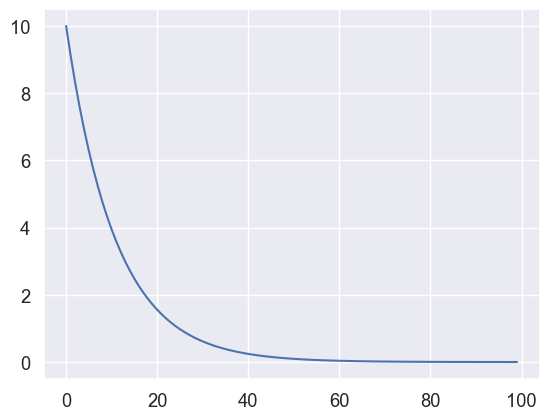

In [30]:
plt.plot(D.sigmas.cpu().numpy());

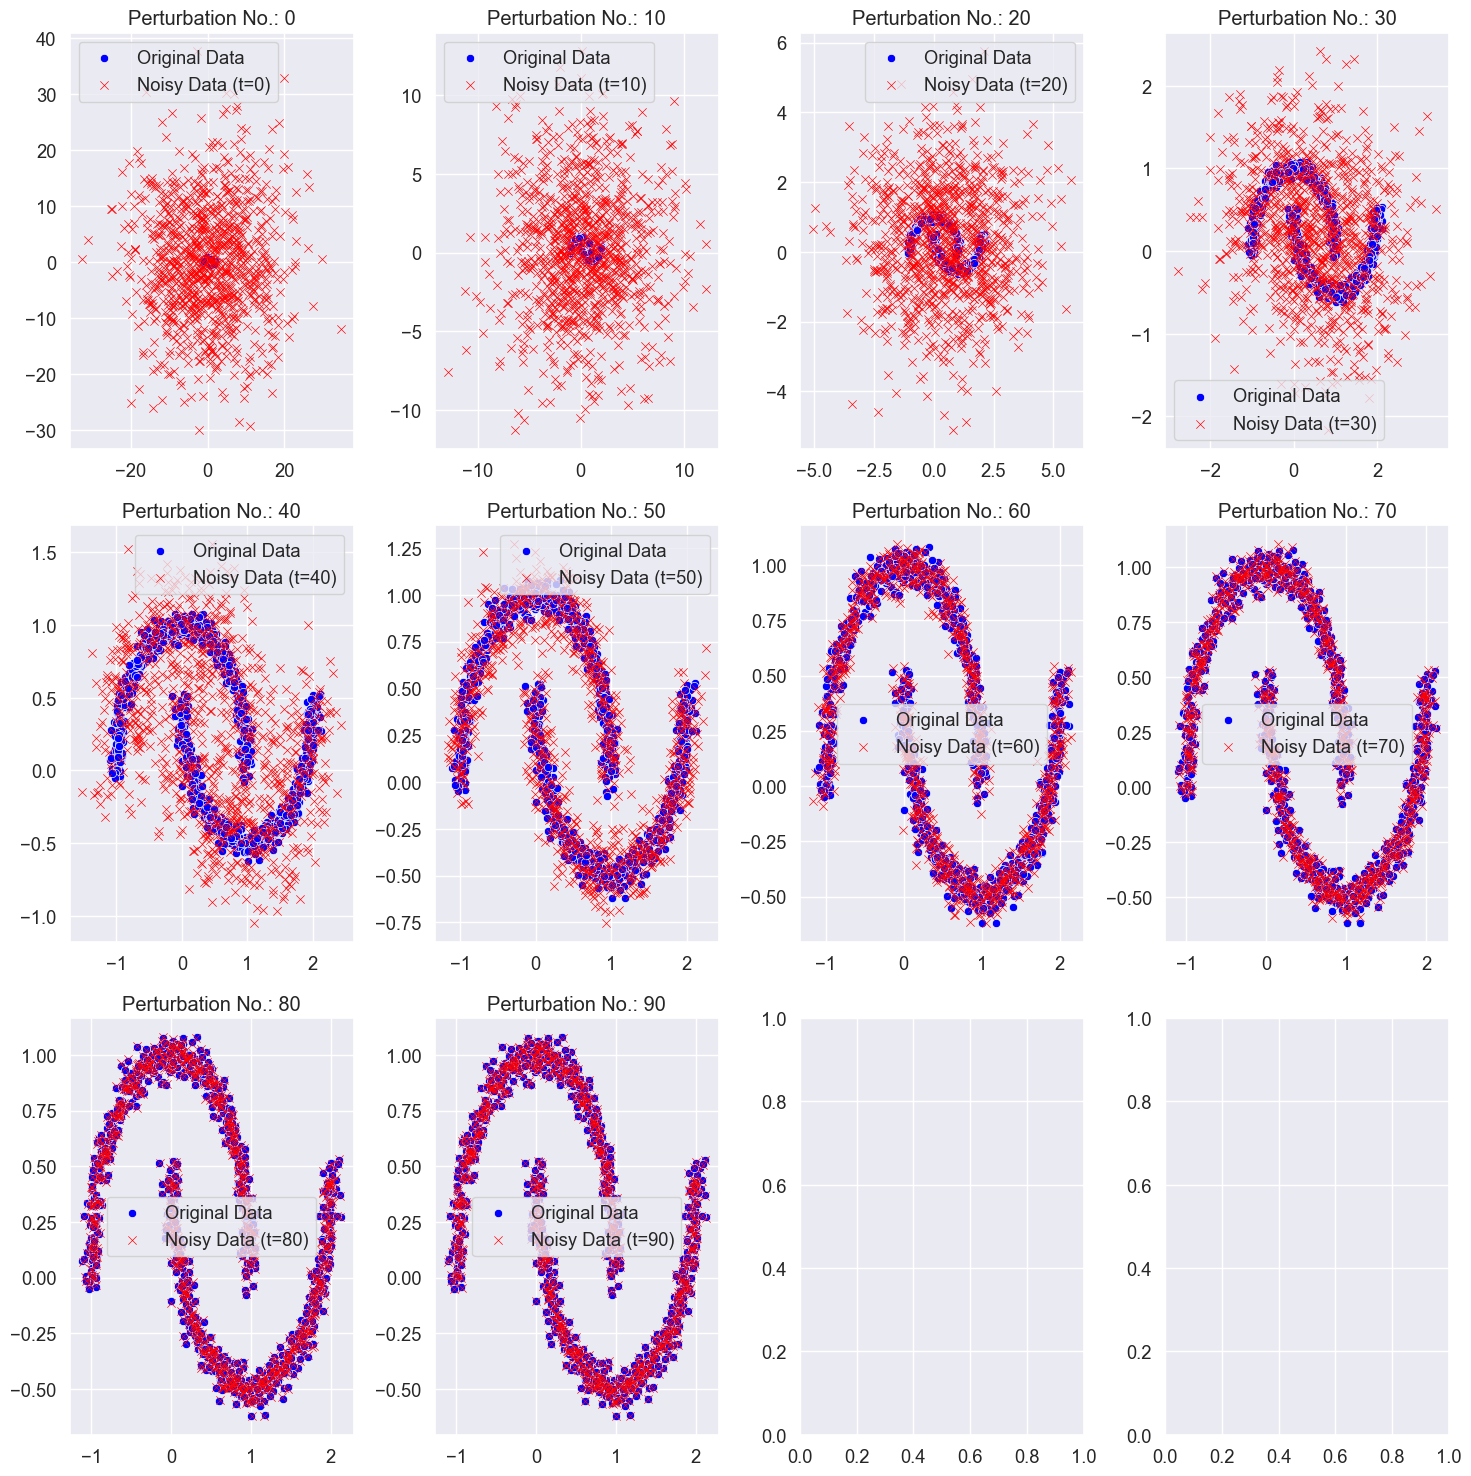

In [31]:
# Cell for debugging diffuser:

# Calculate the number of rows and columns for subplots
plot_every = 10  # Plot every 10th timestep
num_timesteps = D.perturbations
num_plots = num_timesteps // plot_every
num_cols = min(4, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Sample noisy data points from the DDM at every 10th timestep and create subplots
for t in range(num_timesteps):
    if t % plot_every == 0:  # Plot every 10th timestep
        noisy_data, _ = D.forwards_diffusion(X, t)
        plot_num = t // plot_every
        row = plot_num // num_cols
        col = plot_num % num_cols

        # Convert noisy_data to CPU tensor for plotting
        noisy_data_cpu = noisy_data.cpu()

        # Scatter plots using Seaborn
        sns.scatterplot(x=X[:, 0].cpu().numpy(), y=X[:, 1].cpu().numpy(), color='blue', marker='o', label='Original Data', ax=axs[row, col])
        sns.scatterplot(x=noisy_data_cpu[:, 0].numpy(), y=noisy_data_cpu[:, 1].numpy(),
                        color='red', marker='x', label=f'Noisy Data (t={t})', ax=axs[row, col])
        
        axs[row, col].set_title(f'Perturbation No.: {t}')
        axs[row, col].legend()

plt.tight_layout()
plt.show()